## Using PySpark to Explore and summarize the dataset:

In this project, Pyspark with Panads APIs wil be used which provide the familiar pandas interfaces to mainpulate and process large dataset managed by PySpark.

In [2]:
# configure checkpoints directory that can be used to save
sc.setCheckpointDir("hdfs://localhost:9000/checkpoint/")

In [3]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [4]:
import pandas as pd
import numpy as np
import pyspark
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Checking Pandas version:
print(pd.__version__)

2.2.2


In [5]:
# Printing the version of PySpark 
pyspark.__version__

'3.4.2'

In [5]:
# imporing Amazon Sotcks dataset stored on HDFS
psdf = ps.read_csv('/ca3/amazon.csv')

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [6]:
# Confirming the type of dataframe object:
type(psdf)

pyspark.pandas.frame.DataFrame

In [7]:
# Checking the dataset main columns
psdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [8]:
psdf.describe()

24/04/15 18:02:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Open,High,Low,Close,Adj Close,Volume
count,6770.000000,6770.000000,6770.000000,6770.000000,6770.000000,6.770000e+03
mean,35.692191,36.117770,35.235396,35.686546,35.686546,1.391543e+08
std,51.682349,52.279975,51.038981,51.664688,51.664688,1.386193e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,2.060000,2.098500,2.019000,2.058500,2.058500,6.602200e+07
50%,8.059500,8.229000,8.029500,8.091000,8.091000,1.029340e+08
75%,48.862499,49.075500,48.342499,48.794998,48.794998,1.575780e+08
max,187.240005,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [9]:
psdf.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int32
dtype: object

In [10]:
psdf.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
psdf.duplicated().sum()

0

To predict the stocks price, a new variable can be used that is based on the mean between the High, Low and Adj Close daily price of the stock.

In [12]:
ps.set_option('compute.ops_on_diff_frames', True)
psdf["avg_price"] = psdf[['High', 'Low','Adj Close']].mean(axis=1)

In [13]:
# Adding columns with the year and week date:

psdf["month"] = psdf["Date"].astype('datetime64').dt.month
psdf["year"] = psdf["Date"].astype('datetime64').dt.year

In [14]:
psdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume,avg_price,month,year
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,0.106424,5,1997
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,0.090278,5,1997
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,0.085070,5,1997
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,0.083681,5,1997
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,0.074132,5,1997


In [31]:
psdf.sort_index(inplace=True)

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


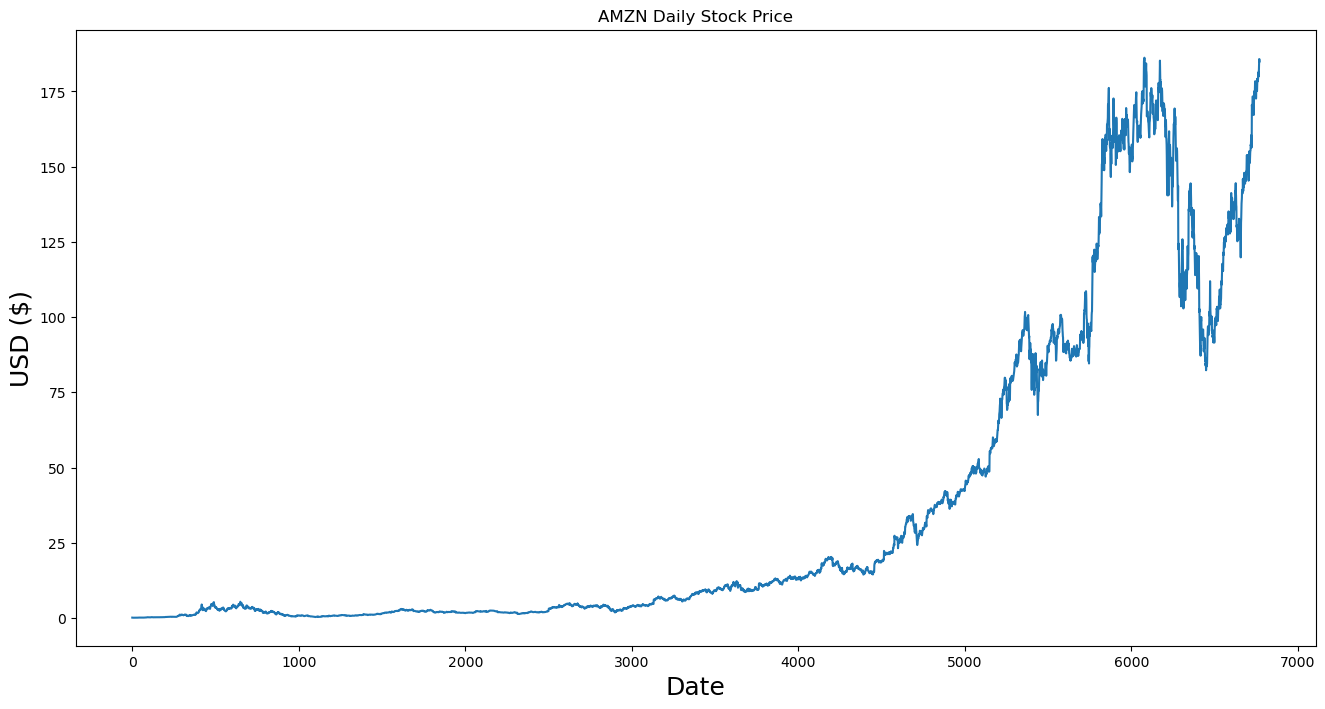

In [32]:
# Plotting the daily price of the stocks:

plt.figure(figsize=(16,8))
plt.title('AMZN Daily Stock Price')
plt.plot("avg_price",data=psdf)
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)

plt.show()


Based on the Graph, the data is non-stationary, as the stock price is a function of the date ( the time) of the observation.

In [33]:
def agg_monthly_annually(psdf, period="monthly"):
    # A function that takes a pyspark dataframe with columns avg_price, week_num, and year_num, and 
    # return a weekly or annual aggregation
    
    aggregations = { 
        "avg_price":"mean" 
    }
    
    if period == "monthly":
        groupby_col = ["year","month"]
    elif period == "annual":
        groupby_col = ["year"]
    else:
        raise Exception("Wrong aggregation value")
    
    new_psdf = psdf.groupby(groupby_col).agg(aggregations)
    new_psdf.reset_index(inplace=True)
    new_psdf.sort_values(by=groupby_col, inplace=True)
    new_psdf.reset_index(inplace=True,drop=True)
    return new_psdf 

In [34]:
monthly_psdf = agg_monthly_annually(psdf)
annual_psdf = agg_monthly_annually(psdf, period="annual")

In [35]:
monthly_psdf.head()

,year,month,avg_price
0,1997,5,0.080737
1,1997,6,0.077001
2,1997,7,0.109620
3,1997,8,0.110995
4,1997,9,0.173520


/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


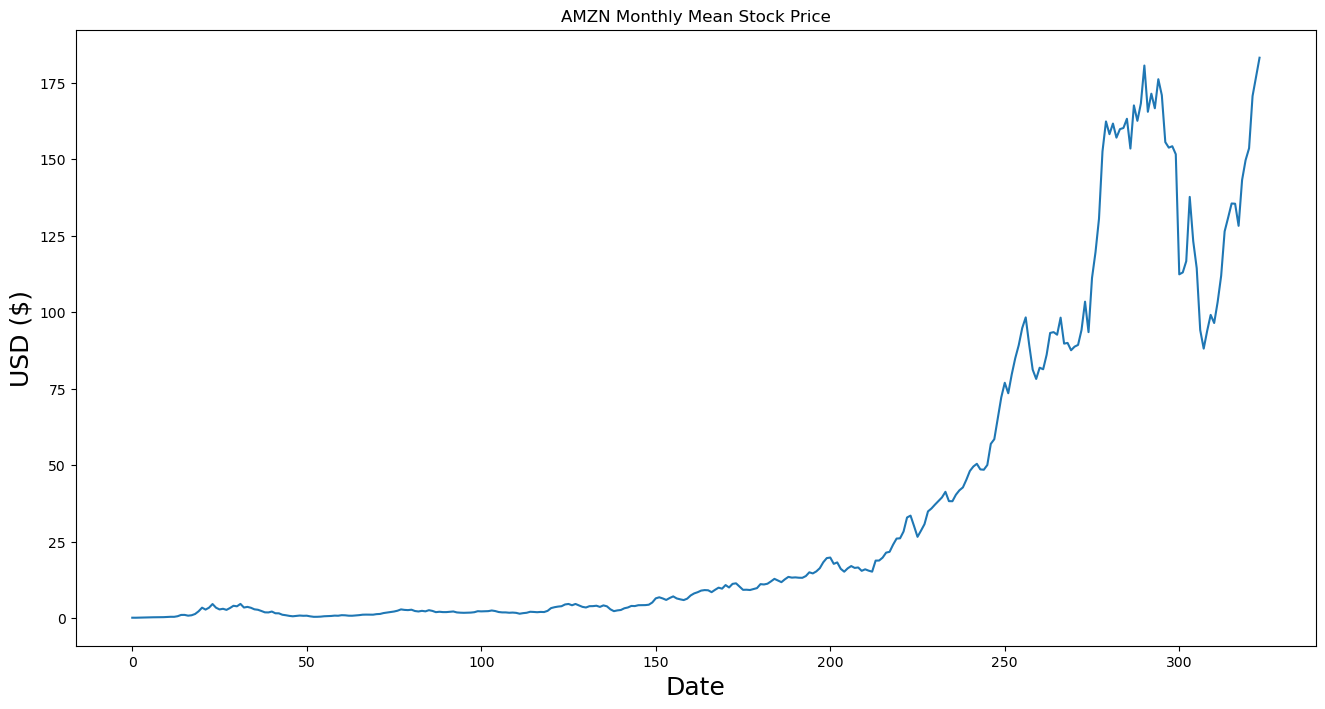

In [36]:
plt.figure(figsize=(16,8))
plt.title('AMZN Monthly Mean Stock Price')
plt.plot("avg_price",data=monthly_psdf)
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)

plt.show()

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


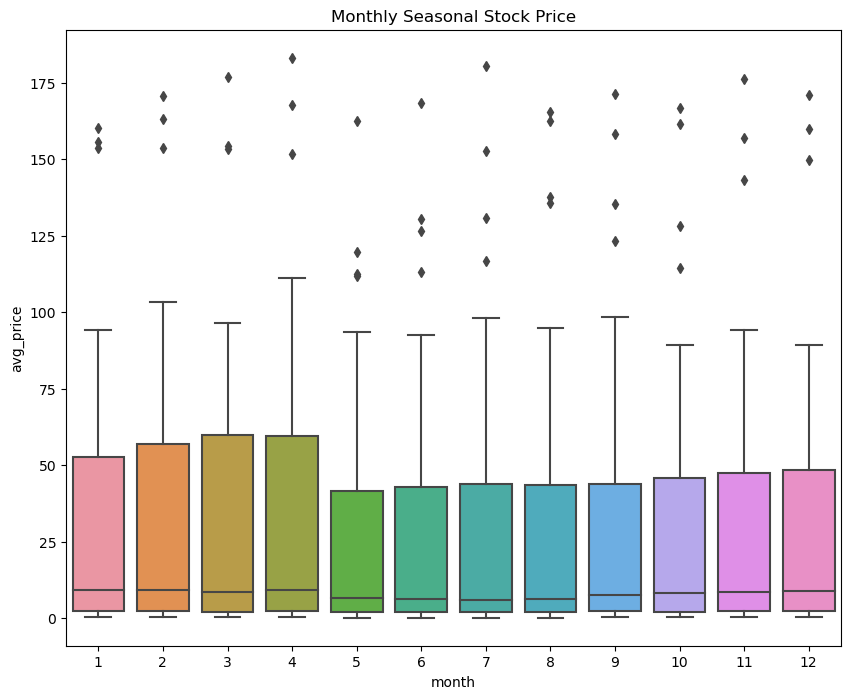

In [37]:
sns.boxplot(x="month",y="avg_price", data=monthly_psdf.to_pandas()).set(
    title="Monthly Seasonal Stock Price"
)
plt.show()

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


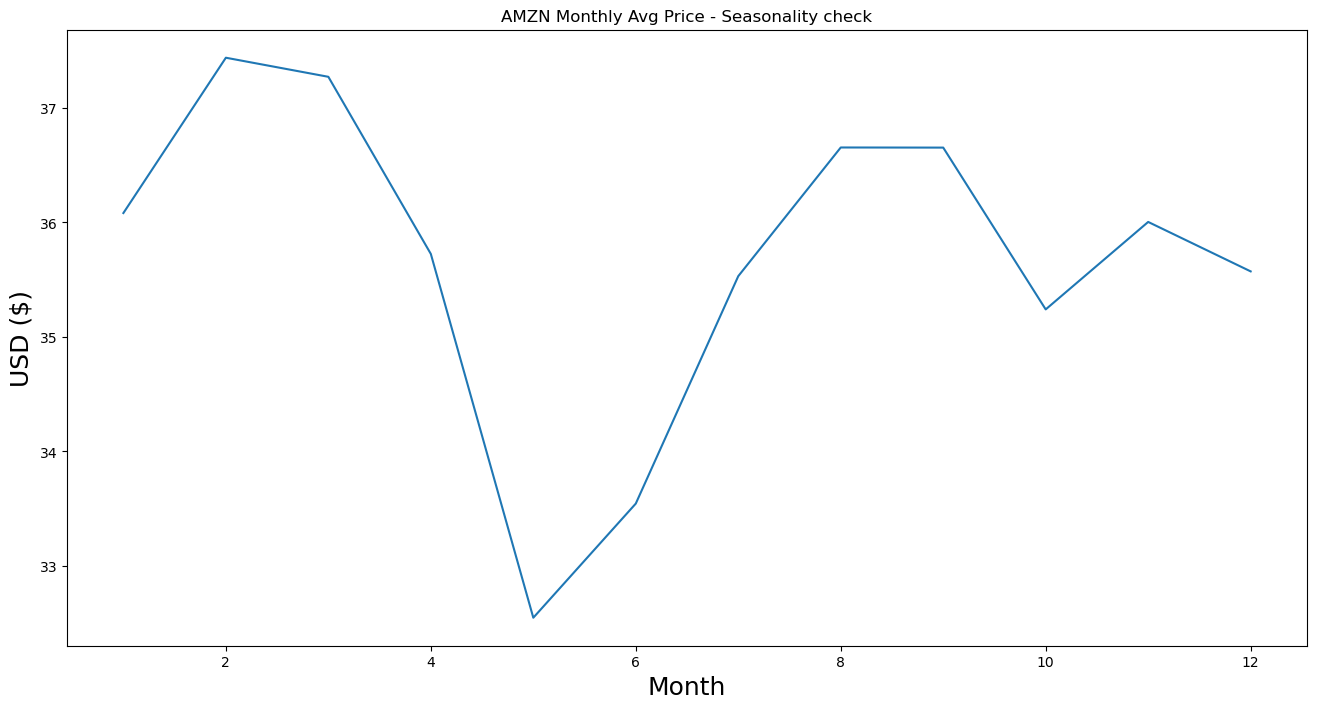

In [38]:
# A graph with the monthly average
monthly_mean_psdf = psdf.groupby("month").agg({"avg_price":"mean"}).sort_index()
plt.figure(figsize=(16,8))
plt.title('AMZN Monthly Avg Price - Seasonality check')
plt.plot("avg_price",data=monthly_mean_psdf)
plt.xlabel('Month', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)
plt.show()

From the previous graphs, we can concluse that there is no clear seasonality in the data, besides a slight dip in the month of may

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


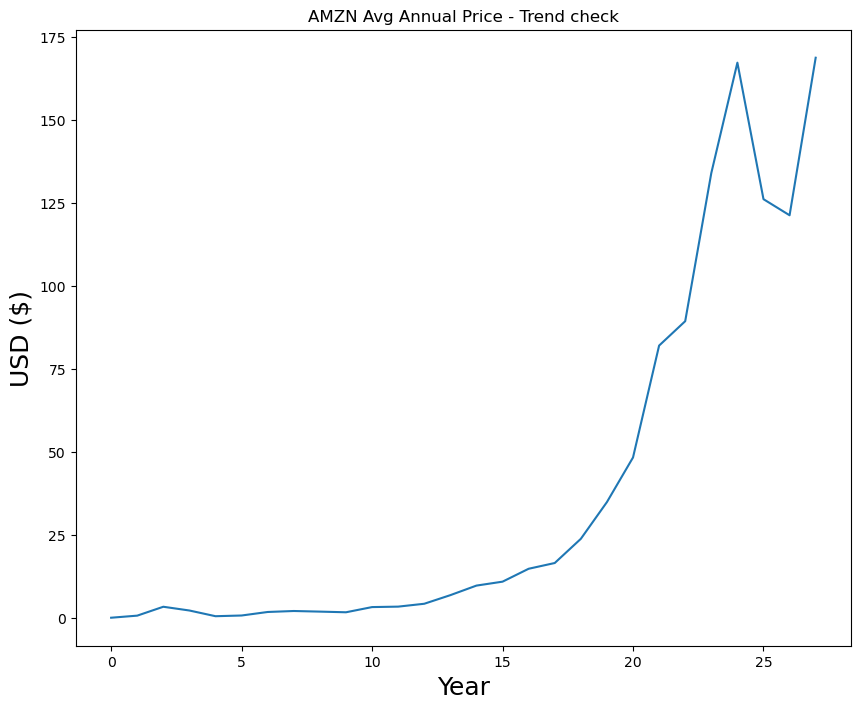

In [39]:
plt.title('AMZN Avg Annual Price - Trend check')
plt.plot("avg_price",data=annual_psdf)
plt.xlabel('Year', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)
plt.show()


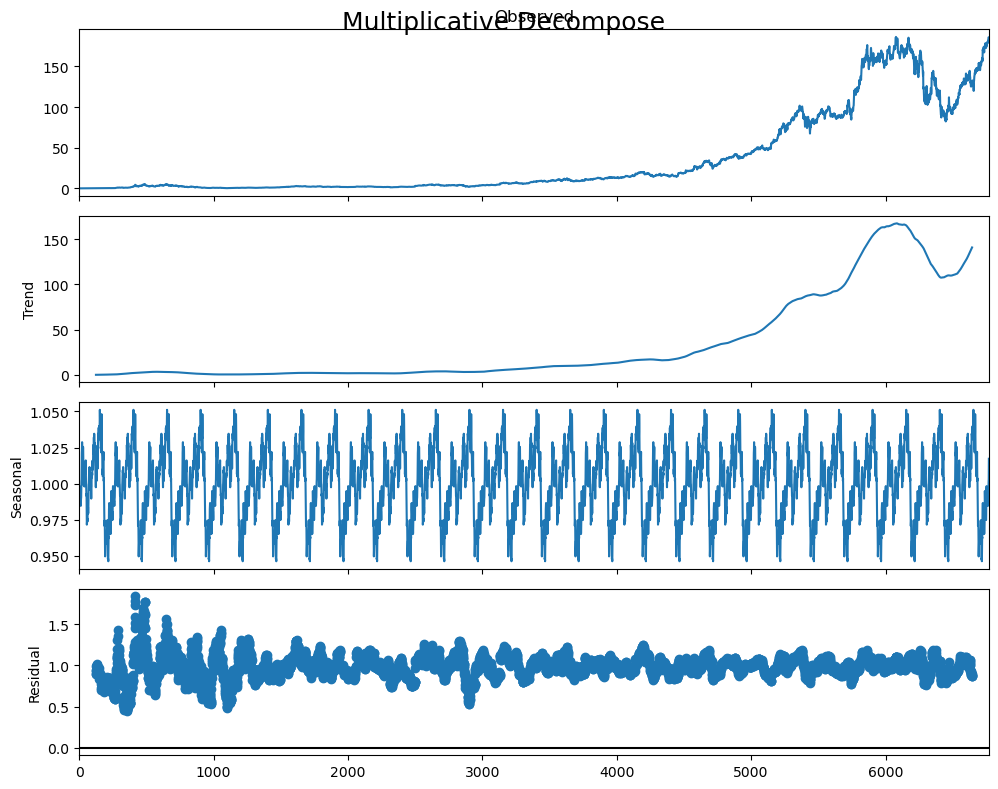

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

avg_price = psdf["avg_price"].to_numpy()

# Multiplicative Decomposition 
result_mul = seasonal_decompose(avg_price, model='multiplicative', period=250 )


# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=18)
plt.show()

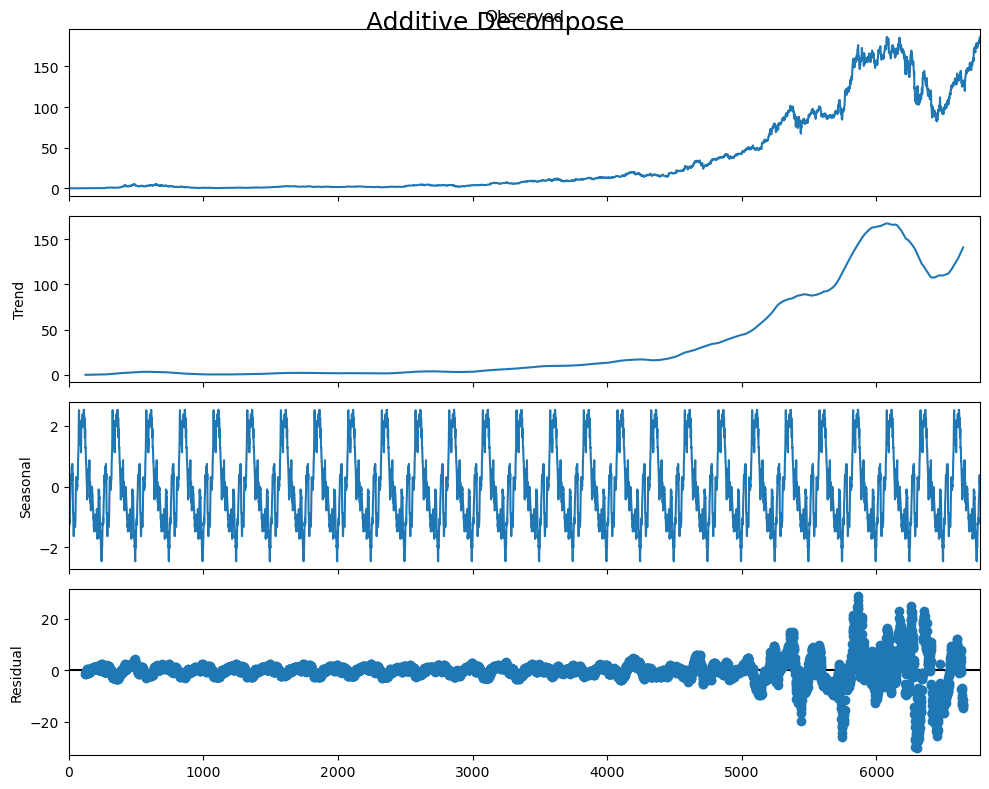

In [41]:
# Additive Decomposition
result_add = seasonal_decompose(avg_price, model='additive', period=250)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result_add.plot().suptitle('Additive Decompose', fontsize=18)
plt.show()

## Investigating Autocorrelation:

Visualizing the changes in Autocorrelation with different lags, between 1, to 100, to help to deciding the best window

In [42]:
lag_autocorr = []
avg_price = psdf.avg_price

for lag in [5, 20, 40, 60, 250, 500, 1000, 2000]:
    lag_autocorr.append([lag, avg_price.autocorr(lag=lag)])

df_lag_autocorr = pd.DataFrame(lag_autocorr, columns=["Lag","Autocorrelation"])
    
    

24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 2

24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 2

24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 2

24/04/14 21:15:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/14 21:15:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [43]:
df_lag_autocorr.head(10)

,Lag,Autocorrelation
0,5,0.998550
1,20,0.994327
2,40,0.989389
3,60,0.983736
4,250,0.919226
5,500,0.871606
6,1000,0.848044
7,2000,0.876572


In [44]:
def add_graph_info_lag(ax=None, lag=None, df=None, color='r'):
    
    lag_idx = df[df['Lag'] == lag].index[0]
    
    # Getting the Autocorrelation value at the index
    autocorr_at_x_lag = df.loc[lag_idx, 'Autocorrelation']
    
    # Adding vertical and horizontal lines at Lag = x
    ax.axvline(x=lag, color=color, linestyle='--')
    ax.axhline(y=autocorr_at_x_lag, color=color , linestyle='--')
    
    # Adding ticks and annotations for the intersection point
    ax.set_xticks(ax.get_xticks().tolist() + [lag])
    ax.set_yticks(ax.get_yticks().tolist() + [autocorr_at_x_lag])
    # Adding text annotation for the Autocorrelation value
    ax.annotate(f'({lag}, {autocorr_at_x_lag:.2f})', xy=(lag, autocorr_at_x_lag),
                    xytext=(lag + 0.05 * max(df['Lag']), autocorr_at_x_lag + 0.01),
                    arrowprops=dict(facecolor=color, arrowstyle='->',color=color))
    
    

/home/hduser/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hduser/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


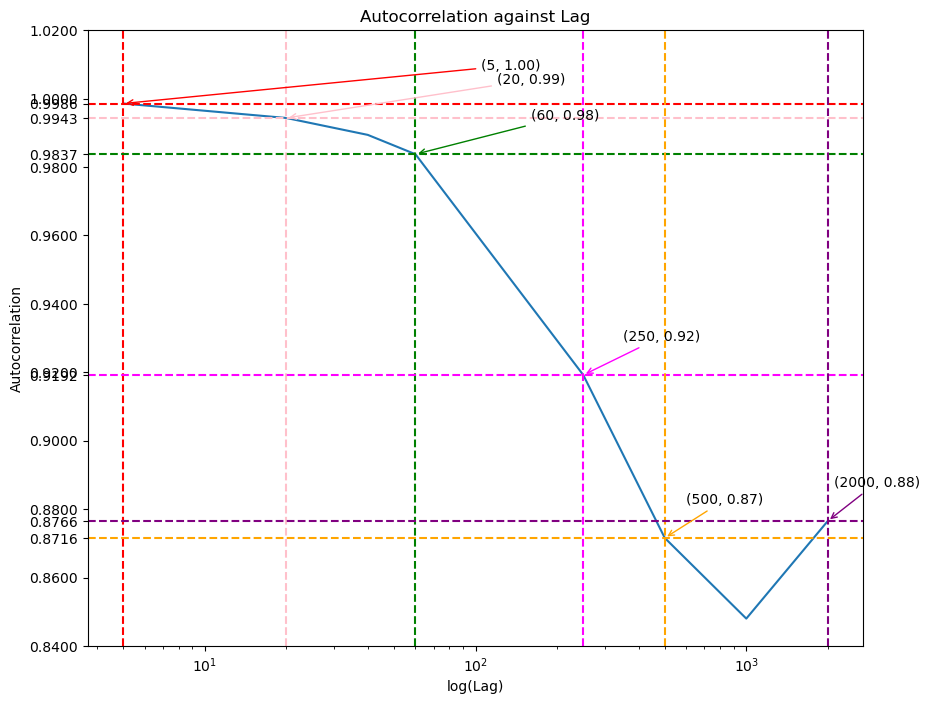

In [45]:
# df_lag_autocorr.plot(x="Lag",y="Autocorrelation")

plt.figure(figsize=(10, 8))

ax = sns.lineplot(data=df_lag_autocorr, x="Lag", y="Autocorrelation")



add_graph_info_lag(ax, lag=5, df=df_lag_autocorr)

add_graph_info_lag(ax, lag=20, df=df_lag_autocorr, color = 'pink')

add_graph_info_lag(ax, lag=60, df=df_lag_autocorr, color = 'g')

add_graph_info_lag(ax, lag=250, df=df_lag_autocorr, color = "magenta")

add_graph_info_lag(ax, lag=500, df=df_lag_autocorr, color = "orange")

add_graph_info_lag(ax, lag=2000, df=df_lag_autocorr, color="purple")





# Adding labels and title
plt.xlabel('log(Lag)')
# Setting x-axis scale to logarithmic
ax.set_xscale('log')
plt.ylabel('Autocorrelation')

plt.title('Autocorrelation against Lag')


plt.show()

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


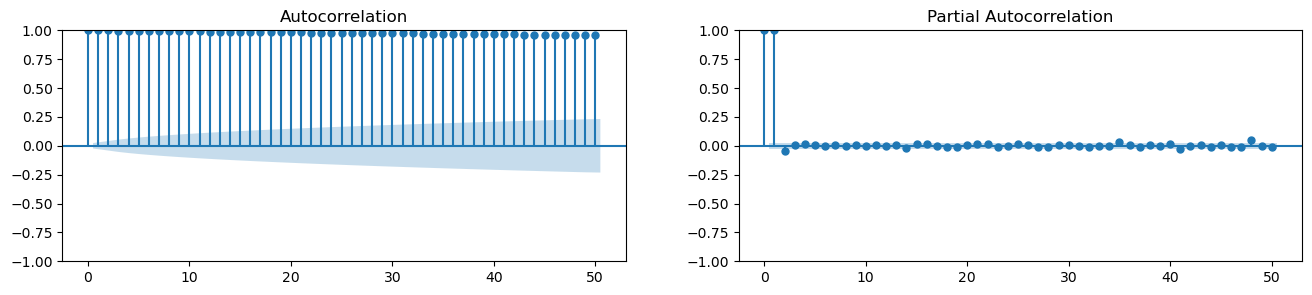

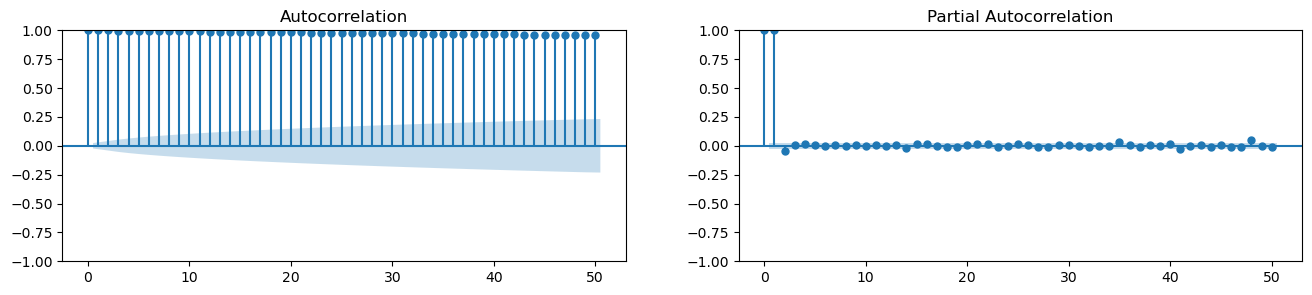

In [46]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(psdf.avg_price.tolist(), lags=50, ax=axes[0])
plot_pacf(psdf.avg_price.tolist(), lags=50, ax=axes[1])

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


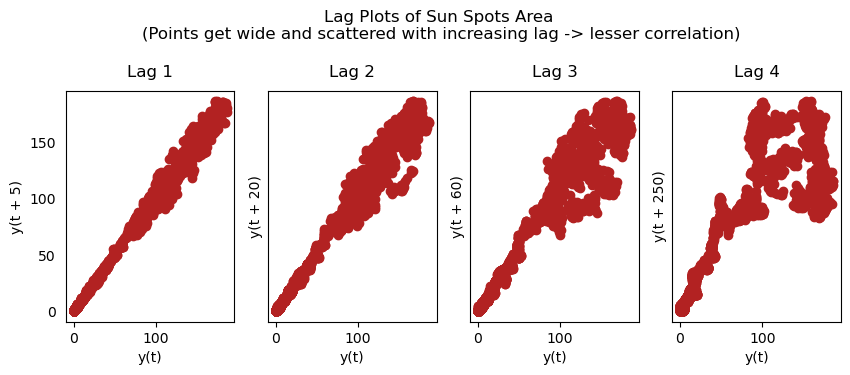

In [47]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

lags = [5, 20, 60, 250]

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(psdf.avg_price, lag=lags[i], ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

plt.show()

From this graph, we can see that the autocorrelation did not suffer from a major degrdation till a lag of 60, then the autocorrelation rate descending rate increased.

As such, in the ML training, it can the performance can be compared with windows of (5, 20, 60, 90)

## Build LSTM model to predict stock price:

### 1. Prepare and summarize the large dataset: 

In [77]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import metrics, losses
import keras
import math
from keras.callbacks import EarlyStopping


In [78]:
psdf.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int32
avg_price    float64
month          int64
year           int64
dtype: object

In [79]:
psdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume,avg_price,month,year
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,0.106424,5,1997
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,0.090278,5,1997
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,0.085070,5,1997
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,0.083681,5,1997
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,0.074132,5,1997


In [80]:
psdf.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int32
avg_price    float64
month          int64
year           int64
dtype: object

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


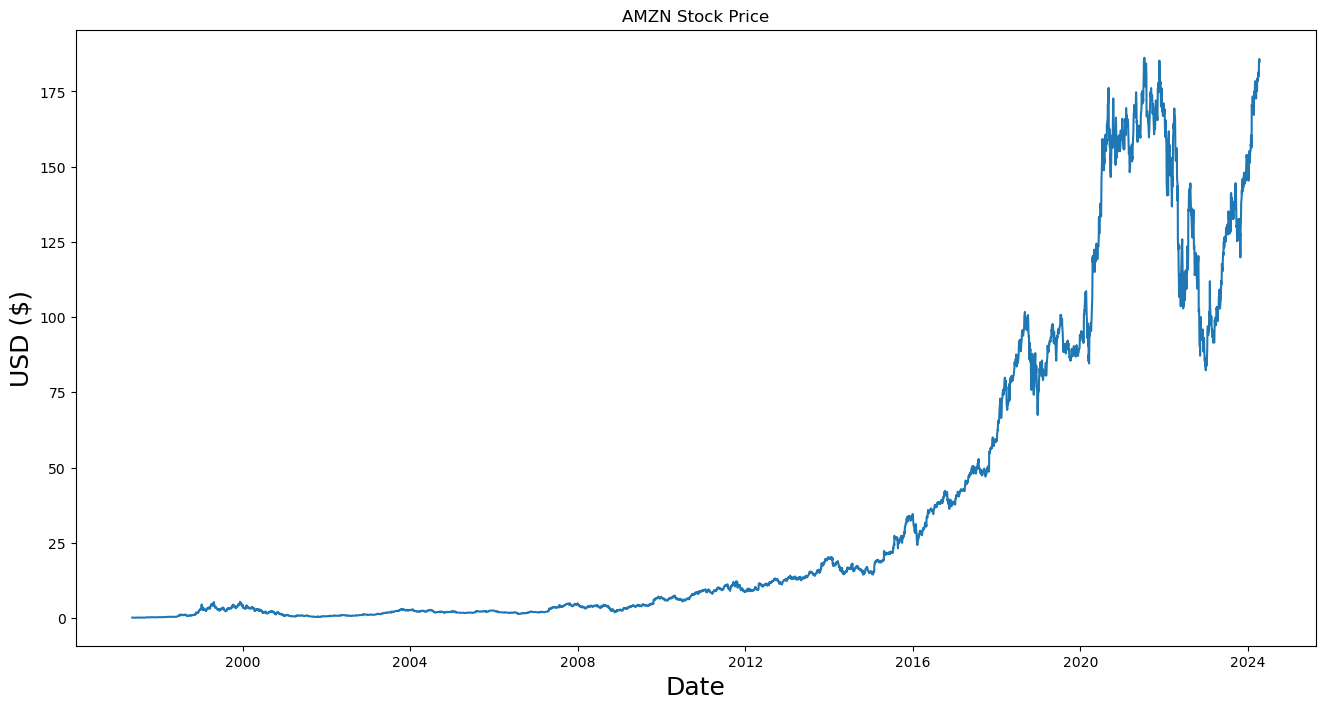

In [15]:
plt.figure(figsize=(16,8))
plt.title('AMZN Stock Price')
plt.plot(psdf["Date"],psdf['avg_price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD ($)', fontsize=18)
plt.show()

Since the data following year 2020 have a different trend, it will be hard to predict based on historical data. Hence, will focus on the data before 2020.

In [82]:
avg_price_data = psdf.filter(['avg_price'])
# To convert to a numpy array:
dataseries = avg_price_data.values

/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [83]:
def split_train_test_data(dataseries, train_test_ratio ,window_size, scaler = None):
    
    x_train, y_train, x_test, y_test = [] , [], [] , []
    
    if scaler:
        dataseries = scaler.fit_transform(dataseries)
    
    len_train_data =  math.ceil( len(dataseries) * train_test_ratio )
    train_data = dataseries[0:len_train_data, :]
    
    start_test_data = len_train_data - window_size
    test_data = dataseries[start_test_data:, :]

    
    # Spliting the Train data:
    for i in range(window_size, len(train_data)):
        x_train.append(train_data[i-window_size:i, 0])
        y_train.append(train_data[i,0])
    

    
    # Splitting the test data:
    y_test = dataseries[len_train_data:, :]
    for i in range(window_size, len(test_data)):
        x_test.append(test_data[i-window_size:i, 0])


    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [84]:
scaler = MinMaxScaler(feature_range=(0,1))

In [85]:
WINDOW_SIZE = 20
TRAIN_TEST_SPLIT_RATIO = 0.8
x_train, y_train, x_test, y_test = split_train_test_data(dataseries, TRAIN_TEST_SPLIT_RATIO, WINDOW_SIZE, scaler)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5396, 20), (5396,), (1354, 20), (1354, 1))

In [86]:
def create_model(
    units_num=10,
    learning_rate = 1e-3,
    optimizer=keras.optimizers.Adam,
):
    """
    units_num: the diemnsion of the hidden state
    window_size: the size of the window based on which infer the next value.
    learning_rate: changes the learning steps for the optimization algorithms
    optimizer: defined the optimization algorithm 
    """
    
    model = Sequential()
    
    model.add(LSTM(units_num, return_sequences = False, input_shape = (x_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", 
                  optimizer=optimizer(learning_rate),
                  metrics=[metrics.MeanAbsolutePercentageError()],
              
                 )
    return model


In [93]:
def eval_model( model=None,
               x_test=None,
               y_test=None
              ):

    
    # run the model to predict
    predictions = model.predict(x_test)
    
    # reverse the scaling for the predicted values and y_test
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)
    
    # Performance metrics:
    try:
        mse = mean_squared_error(y_test, predictions)
    except ValueError:
        mse = np.nan
    try:
        mape = mean_absolute_percentage_error(y_test, predictions)
    except ValueError:
        mape = np.nan
    
    return {
        "mse":mse, 
        "mape":mape, 
           }
    


In [94]:
def assess_model_config( 
    learning_rates=[],
    optimizers=[],
    batch_sizes=[],
    x_test=None,
    y_test=None,
    x_train=None,
    y_train=None
    
):
    columns = ["optimizer", "learning_rate", "batch_size", "epochs", "MSE","MAPE", "Model" ]
    perf = []
    mape= []
    x_val = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    y_val = np.array(y_test).reshape(-1, 1)
    
    # reshape the features and target dataframes:
    x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    y_test =  np.array(y_test).reshape(-1, 1)
    x_train =np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=5, 
                                   verbose=1, 
                                   restore_best_weights=True,
                                   start_from_epoch=5
                                  )
    
    for optimizer in optimizers:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"Creating Model with Optimization: {optimizer}, Learning rate: {lr}, and batch_size: {batch_size}")
                model = create_model(
                                     learning_rate=lr,
                                     optimizer=optimizer
                                    )
                print(f"Fitting the model")
                history = model.fit(x_train,
                      y_train,
                      batch_size = 32,
                      epochs = 100,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping]
                     )
                
                best_epoch = np.argmin(history.history['val_loss']) + 1  # Add 1 because epochs start from 1
                print(f"Number of epochs done is: {best_epoch}")
                
                print(f"checking performance metrics")
                perf_metrics = eval_model(model=model, x_test=x_test, y_test=y_test)
                print(f"The performance metrics for this model are: {perf_metrics}")
                perf.append([
                    optimizer, 
                    lr, 
                    batch_size, 
                    best_epoch, 
                    perf_metrics["mse"], 
                    perf_metrics["mape"], 
                    model 
                ])
        
    results_df = pd.DataFrame( perf, columns=columns )
        
    return results_df            

In [97]:
optimizers = [
    keras.optimizers.Adam,
    keras.optimizers.SGD,
    keras.optimizers.RMSprop,
]


lrs = [
    1e-4,
    1e-2, 
    0.1,  
]

batch_sizes = [
    8, 
    16, 
    32
]



results_df = assess_model_config(
    optimizers=optimizers,
    learning_rates=lrs,
    batch_sizes=batch_sizes,
    x_test = x_test,
    y_test = y_test,
    x_train = x_train,
    y_train = y_train,
)

Creating Model with Optimization: <class 'keras.src.optimizers.adam.Adam'>, Learning rate: 0.0001, and batch_size: 8
Fitting the model
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0102 - mean_absolute_percentage_error: 402.8079 - val_loss: 0.2383 - val_mean_absolute_percentage_error: 67.9634
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0059 - mean_absolute_percentage_error: 1032.6389 - val_loss: 0.1429 - val_mean_absolute_percentage_error: 52.5608
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0035 - mean_absolute_percentage_error: 854.8099 - val_loss: 0.0549 - val_mean_absolute_percentage_error: 32.6303
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014 - mean_absolute_percentage_error: 571.1426 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 7.8416
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.8774e-04 - mean_absolute_percentage_error: 310.6557 - val_loss: 0.0022 - val_mean_absolute_pe

Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6366e-05 - mean_absolute_percentage_error: 31.3370 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 6.0127
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6896e-05 - mean_absolute_percentage_error: 63.9821 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 5.6747
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.5833e-05 - mean_absolute_percentage_error: 28.3685 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 3.5694
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6504e-05 - mean_absolute_percentage_error: 36.4161 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 3.3729
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.9182e-05 - mean_absolute_percentage_error: 33.3408 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 3.9048
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3826e-05 - mean_absolute_percentage_error

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0294e-05 - mean_absolute_percentage_error: 35.6985 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.9438
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5888e-05 - mean_absolute_percentage_error: 48.1265 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.1414
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3748e-05 - mean_absolute_percentage_error: 43.7771 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 3.3966
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.7361e-05 - mean_absolute_percentage_error: 54.4923 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 3.1585
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9004e-05 - mean_absolute_percentage_error: 50.5097 - val_loss: 8.5094e-04 - val_mean_absolute_percentage_error: 2.8333
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 6.
Number of epochs done is: 10


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7676e-04 - mean_absolute_percentage_error: 300.6707 - val_loss: 0.0867 - val_mean_absolute_percentage_error: 35.9747
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 6.
Number of epochs done is: 10
checking performance metrics
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
The performance metrics for this model are: {'mse': 7687.590352903268, 'mape': 0.6271150889856658}
Creating Model with Optimization: <class 'keras.src.optimizers.sgd.SGD'>, Learning rate: 0.01, and batch_size: 32
Fitting the model
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0156 - mean_absolute_percentage_error: 1070.8936 - val_loss: 0.4902 - val_mean_absolute_percentage_error: 97.3468
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0119 - mean_absolute_percentage_error: 1459.8948 - val_loss: 0.4295 - val_mean_absolute_percentage_error: 90.8521
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.01

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mean_absolute_percentage_error: 375.4655 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 7.4295
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3860e-05 - mean_absolute_percentage_error: 83.1121 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 5.4058
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4574e-05 - mean_absolute_percentage_error: 29.9354 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 5.3873
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5272e-05 - mean_absolute_percentage_error: 33.7411 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 5.4528
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6222e-05 - mean_absolute_percentage_error: 26.5833 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 5.5659
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8257e-05 - mean_absolute_percentage_error: 28.0

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3782e-04 - mean_absolute_percentage_error: 206.4285 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 4.3240
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1499e-04 - mean_absolute_percentage_error: 220.5876 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 5.4100
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0394e-04 - mean_absolute_percentage_error: 182.1179 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.5536
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0820e-04 - mean_absolute_percentage_error: 217.9805 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 9.4745
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.7966e-05 - mean_absolute_percentage_error: 166.9131 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 5.4951
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.0147e-05 - mean_absolute_percentage_error: 182.8

In [102]:
results_sorted = results_df.sort_values(by="MSE", ascending=True)
results_sorted.reset_index(inplace=True, drop=True)
results_sorted.head(10)

,optimizer,learning_rate,batch_size,epochs,MSE,MAPE,Model
0,<class 'keras.src.optimizers.adam.Adam'>,0.0100,8,23,6.827274,0.015096,"<Sequential name=sequential_48, built=True>"
1,<class 'keras.src.optimizers.adam.Adam'>,0.0100,32,10,20.294150,0.025453,"<Sequential name=sequential_50, built=True>"
2,<class 'keras.src.optimizers.adam.Adam'>,0.0100,16,10,37.538691,0.035674,"<Sequential name=sequential_49, built=True>"
3,<class 'keras.src.optimizers.adam.Adam'>,0.0001,8,11,37.781048,0.037415,"<Sequential name=sequential_45, built=True>"
4,<class 'keras.src.optimizers.adam.Adam'>,0.0001,32,5,40.138102,0.037305,"<Sequential name=sequential_47, built=True>"
5,<class 'keras.src.optimizers.rmsprop.RMSprop'>,0.1000,32,5,67.722795,0.064168,"<Sequential name=sequential_71, built=True>"
6,<class 'keras.src.optimizers.rmsprop.RMSprop'>,0.0100,8,4,97.796558,0.054607,"<Sequential name=sequential_66, built=True>"
7,<class 'keras.src.optimizers.rmsprop.RMSprop'>,0.0100,32,10,100.367618,0.054073,"<Sequential name=sequential_68, built=True>"
8,<class 'keras.src.optimizers.adam.Adam'>,0.1000,16,10,105.643451,0.049415,"<Sequential name=sequential_52, built=True>"
9,<class 'keras.src.optimizers.sgd.SGD'>,0.1000,32,3,110.647052,0.055836,"<Sequential name=sequential_62, built=True>"


In [103]:
top_model = results_sorted.loc[0, "Model"]

In [116]:
def graph_predictions(model, scaler, raw_data ,x_test, y_test ):
    
    x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    y_test =  np.array(y_test).reshape(-1, 1)
    
    # running the model to get predictions
    predictions = model.predict(x_test)
    # applying inverse scaling to the data.
    predictions = scaler.inverse_transform(predictions)
    

    
    training_len =  math.ceil( len(raw_data) * TRAIN_TEST_SPLIT_RATIO )
    train_data = raw_data[:training_len]
    val_data = raw_data[training_len:].to_pandas()
    val_data['Predictions'] = predictions
    
    plt.figure(figsize=(16,8))
    plt.title('LSTM Deep Learning Neural Networks Model')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Average Stock Price USD($)', fontsize=18)
    plt.plot(train_data['avg_price'])
    plt.plot(val_data[['avg_price', 'Predictions']])
    plt.legend(['Train', 'Actual', 'Predictions'], loc = 'lower right')
    plt.show()
    

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


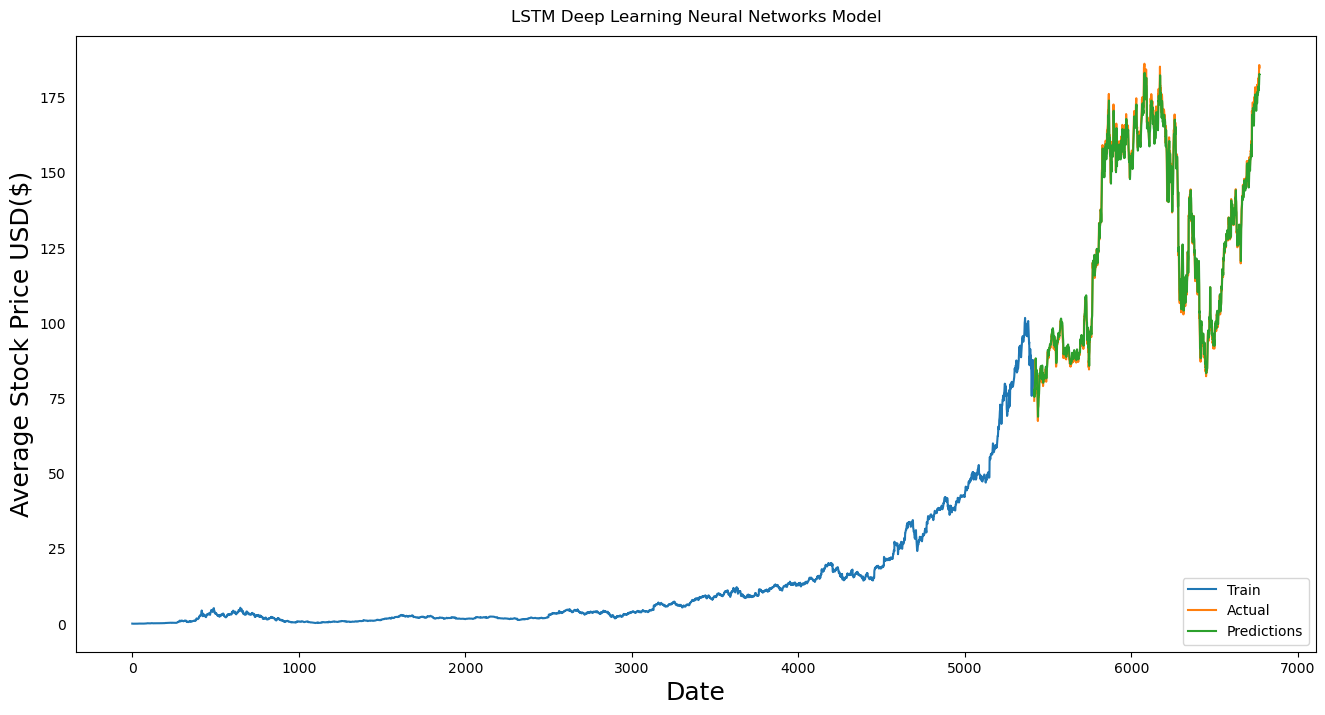

In [117]:
graph_predictions(
    model=top_model,
    scaler=scaler,
    raw_data=avg_price_data,
    x_test=x_test,
    y_test=y_test
)